# Introduction

This is a basic pseudo-code outline for how to perform basic reduction and calibration on HRPO data. You will need to write the code and reduction processes using ccdproc and the other appropriate packages.

# Code outline

1. Import necessary packages
2. Gather all data
3. Prepare for reduction
    - Make master bias
    - Make master dark
    - Make master flat(s)
4. Reduce the data
    - Use ccd_process to perform reduction and calibration
    - Optional: Plate solve images
    - Write out calibrated and solved data to a different directory, or with a different name
---

### Name: 

## 0. Rename this notebook so that it has your name in it and put your name in the comment above.
## 1. Import all of the necessary packages:
    - os
    - sys
    - numpy
    - ccdproc
    - astropy.units
    - aperturePhot.showimage
    

In [2]:
import sys
sys.path.append('/home/idies/persistent/hrpo-pipeline')
from aperturePhot import showimage

In [3]:
import os
import sys
import numpy as np
import ccdproc as ccdp

In [4]:
import astropy.units as u

In [5]:
from aperturePhot import showimage

## 2. Gather all data

Define a string to store the path to the data directory you are working in.
Use `os.path.join` to merge together the string "/home/idies/workspace/" with the data directory path string.

Use `os.chdir` to move into the data directory. This will let us use relative paths instead of absolute.

```
base = "/home/idies/workspace/"
data_dir = ""

path = os.path.join(...)
os.chdir(path)
```

Use the conditional `os.path.exists` to check if there is a directory called "reduced" in the current directory. If there isn't, then make it with os.mkdir

In python you can check a condition with an if statement such as:

```
if condition:
     do something
````
Use `ccdp.ImageFileCollection` on the current directory to get a list of of all the images in the current directory as strings. I refer to this complete collection as `images`
```
images = ccdp.ImageFileCollection(...)
```


In [6]:
base = "/home/idies/workspace/"
data_dir = "Temporary/treed28/scratch/20240903"

#/home/idies/workspace/Temporary/treed28/scratch/20240903/reduced/

path = os.path.join(base, data_dir)
os.chdir(path)

In [7]:
os.path.exists

<function genericpath.exists(path)>

In [8]:
images = ccdp.ImageFileCollection(path)
images.summary

file,simple,bitpix,naxis,naxis1,naxis2,bscale,bzero,date-obs,exptime,exposure,set-temp,ccd-temp,xpixsz,ypixsz,xbinning,ybinning,xorgsubf,yorgsubf,readoutm,imagetyp,focuspos,focustem,object,objctra,objctdec,objctalt,objctaz,objctha,sitelat,sitelong,jd,jd-helio,airmass,focallen,aptdia,aptarea,swcreate,sbstdver,telescop,instrume,observer,notes,unit,flipstat,swowner,filter
str19,bool,int64,int64,int64,int64,float64,float64,str19,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,str10,str11,int64,float64,str10,str8,str9,str8,str8,str8,str8,str9,float64,float64,float64,float64,float64,float64,str34,str21,str30,str14,str1,str1,str3,str1,str23,object
Bias-001Bias.fit,True,16,2,1024,1024,1.0,32768.0,2024-09-04T03:36:24,0.0,0.0,-5.0,-4.8626077500000005,13.0,13.0,1,1,0,0,Monochrome,Bias Frame,8560,630.0,Bias,15 59 25,+25 55 17,31.8628,283.3599,4.4446,30 20 45,-91 04 13,2460557.6502777776,2460557.6487624766,1.8877121610835381,4115.0,508.0,200656.16730637552,MaxIm DL Version 5.24 140606 2EUKY,SBFITSEXT Version 1.0,Highland Road Park Observatory,Apogee USB/Net,,,adu,,LSU Physics-Astronomy-1,--
Bias-002Bias.fit,True,16,2,1024,1024,1.0,32768.0,2024-09-04T03:36:34,0.0,0.0,-5.0,-4.8626077500000005,13.0,13.0,1,1,0,0,Monochrome,Bias Frame,8560,630.0,Bias,15 59 25,+25 55 17,31.8165,283.3809,4.4482,30 20 45,-91 04 13,2460557.6503935186,2460557.64887821,1.8895566249126776,4115.0,508.0,200656.16730637552,MaxIm DL Version 5.24 140606 2EUKY,SBFITSEXT Version 1.0,Highland Road Park Observatory,Apogee USB/Net,,,adu,,LSU Physics-Astronomy-1,--
Bias-003Bias.fit,True,16,2,1024,1024,1.0,32768.0,2024-09-04T03:36:45,0.0,0.0,-5.0,-4.8626077500000005,13.0,13.0,1,1,0,0,Monochrome,Bias Frame,8560,630.0,Bias,15 59 25,+25 55 17,31.7888,283.3935,4.4504,30 20 45,-91 04 13,2460557.650520833,2460557.6490055164,1.8915903480000875,4115.0,508.0,200656.16730637552,MaxIm DL Version 5.24 140606 2EUKY,SBFITSEXT Version 1.0,Highland Road Park Observatory,Apogee USB/Net,,,adu,,LSU Physics-Astronomy-1,--
Bias-004Bias.fit,True,16,2,1024,1024,1.0,32768.0,2024-09-04T03:36:55,0.0,0.0,-5.0,-4.8626077500000005,13.0,13.0,1,1,0,0,Monochrome,Bias Frame,8560,630.0,Bias,15 59 25,+25 55 17,31.7521,283.4101,4.4534,30 20 45,-91 04 13,2460557.6506365743,2460557.64912125,1.8934435927242368,4115.0,508.0,200656.16730637552,MaxIm DL Version 5.24 140606 2EUKY,SBFITSEXT Version 1.0,Highland Road Park Observatory,Apogee USB/Net,,,adu,,LSU Physics-Astronomy-1,--
Bias-005Bias.fit,True,16,2,1024,1024,1.0,32768.0,2024-09-04T03:37:06,0.0,0.0,-5.0,-5.2743735,13.0,13.0,1,1,0,0,Monochrome,Bias Frame,8560,630.0,Bias,15 59 25,+25 55 17,31.7055,283.4312,4.4570,30 20 45,-91 04 13,2460557.650763889,2460557.6492485567,1.8954870060905855,4115.0,508.0,200656.16730637552,MaxIm DL Version 5.24 140606 2EUKY,SBFITSEXT Version 1.0,Highland Road Park Observatory,Apogee USB/Net,,,adu,,LSU Physics-Astronomy-1,--
Bias-006Bias.fit,True,16,2,1024,1024,1.0,32768.0,2024-09-04T03:37:16,0.0,0.0,-5.0,-5.2743735,13.0,13.0,1,1,0,0,Monochrome,Bias Frame,8560,630.0,Bias,15 59 25,+25 55 17,31.6714,283.4467,4.4598,30 20 45,-91 04 13,2460557.6508796294,2460557.64936429,1.8973490812597464,4115.0,508.0,200656.16730637552,MaxIm DL Version 5.24 140606 2EUKY,SBFITSEXT Version 1.0,Highland Road Park Observatory,Apogee USB/Net,,,adu,,LSU Physics-Astronomy-1,--
Bias-007Bias.fit,True,16,2,1024,1024,1.0,32768.0,2024-09-04T03:37:26,0.0,0.0,-5.0,-5.2743735,13.0,13.0,1,1,0,0,Monochrome,Bias Frame,8560,630.0,Bias,15 59 25,+25 55 17,31.6353,283.4631,4.4626,30 20 45,-91 04 13,2460557.6509953705,2460557.6494800234,1.8992153926895932,4115.0,508.0,200656.16730637552,MaxIm DL Version 5.24 140606 2EUKY,SBFITSEXT Version 1.0,Highland Road Park Observatory,Apogee USB/Net,,,adu,,LSU Physics-Astronomy-1,--
Bias-008Bias.fit,True,16,2,1024,1024,1.0,32768.0,2024-09-04T03:37:35,0.0,0.0,-5.0,-5.2743735,13.0,13.0,1,1,0,0,Monochrome,Bias Frame,8560,630.0,Bias,15 59 25,+25 55 17,31.6023,283.4781,4.4652,30 20 45,-91 04 13,2460557.651099537,2460557.649

## 3. Reduction Preparation: Make master bias

Use `images.filter`\* to get only the images with `imagetyp="Bias Frame"`.

Create a master bias frame with *ccdp.combine* on your list of bias frames. Use the median method and specify that `unit="adu"`. I will refer to this master bias frame as `mbias`

Save the master bias with `mbias.write` to `"reduced/mbias.fit"`, add the keyword argument  `overwrite=True` to overwrite the file in case we rerun this entire script on this same directory multiple times.

```
biases = images.filter( ... )
mbias = ccdp.combine(biases, ... )
mbias.write( ...)
```

\*Note the `.filter` method returns an `ImageFileCollection` object, the `.files_filtered` method returns a list of filenames. You can iterate over what is returned by `.filter`, but if you need to iterate over an existing `ImageFileCollection` object without filtering, you can do that with the `.ccds` method, that provides a `CCDData` object to the loop. 

In [9]:
# Filter images to get only the bias frames
biases = images.filter(imagetyp="Bias Frame")

# Create a list of CCDData objects from the filtered bias frames
bias_frames = [ccd for ccd in biases.ccds(ccd_kwargs={'unit': u.adu})]

# Combine the bias frames using the median method
mbias = ccdp.combine(bias_frames, method='median')

# Save the master bias frame, overwriting if necessary
mbias.write("reduced/mbias.fit", overwrite=True)

## 4. Reduction Preparation: Make master dark

Use `images.files_filtered` to get only the images with `imagetyp="Dark Frame"`. I will refer to this collection as `darks`.

Create two empty lists, one to store the reduced darks and one to store the exposure time of each frame. I will refer to the latter as `exptimes`

Use a for loop to iterate over `darks.ccds` . Subtract the `mbias` from each image with `ccdp.subtract_bias` and append it to the first empty list, append to the second empty list the exposure time from the header.

```
exptimes = []
red_darks = []
darks = filtered collection


for ccd in darks.ccds():
    ccd = bias subtracted dark
    Append the cleaned ccd to the red_darks list
    Append ccd.header["exptime"] to the exposure time list.
```

After this, convert your exposure times list to a numpy array. 

Create master dark frame with `ccdp.combine`. Use the median method, set `scale=1/exptimes`, and set `unit="adu"`. I will refer to this as `mdark`

Set the `"exposure"` and `"exptime"` header keywords in `mdark.header` to 1.

Save `mdark` in the reduced data directory.

```
exptimes = np.array(exptimes)
mdark = ccdp.combine (red_darks, ...)
mdark.header["exptime"] = 1
mdark.header["exposure"] = 1

mdark.write(...)

```

In [10]:
# Filter images to get only the dark frames
darks = images.filter(imagetyp="Dark Frame")

# Initialize the lists for reduced darks and exposure times
exptimes = []
red_darks = []

# Iterate over each dark frame, subtracting the master bias and storing results
#for ccd in darks.ccds(ccd_kwargs={'unit': u.adu}):

for ccd in darks.ccds(ccd_kwargs={'unit':u.adu}):    
    # Subtract the master bias from each dark frame
    #cleaned_dark = ccdp.subtract_bias(ccd, mbias)
    cleaned_dark = ccdp.subtract_bias(ccd, mbias)
    
    # Append the cleaned dark frame to the list
    red_darks.append(cleaned_dark)
    
    # Append the exposure time to the exptimes list
    exptimes.append(cleaned_dark.header["exptime"])
    
# Convert the exposure times list to a numpy array
exptimes = np.array(exptimes)

# Create master dark frame with `ccdp.combine`. Use the median method, set `scale=1/exptimes`, and set `unit="adu"`. I will refer to this as `mdark` 
mdark = ccdp.combine(red_darks, method='median', scale=1/exptimes, unit=u.adu) #unit=u.adu

# Set the `"exposure"` and `"exptime"` header keywords in `mdark.header` to 1
mdark.header["exptime"] = 1
mdark.header["exposure"] = 1

# Ensure the 'reduced' directory exists
output_directory = "reduced"
if not os.path.exists(output_directory):
    os.makedirs(output_directory)
    
# Save `mdark` in the reduced data directory
mdark.write(os.path.join(output_directory, "mdark.fit"), overwrite=True)
#mdark.write("reduced/mdark.fit", overwrite=True)

## 5. Reduction Preparation: Make the master flat frames

Flat frames have the added complication that they are specific to each filter. Using nested for loops, we can save from writing the same code multiple times.

- Define a list of filter names as strings
- Create an empty dictionary to store our master flats for later.
- Iterate over the filters in the outer loop.
- Use `images.files_filtered` with `imagetyp="Flat Field"` as well as`filter=filt`.
- Create empty list to store reduced flats.
- Iterate over the flat ccds. Bias subtract, dark subtract with `scale=True, exposure_unit=u.s, exposure_time='exptime'`.
- Append reduced flat to `red_flats`.
- Use `ccdp.combine` on the reduced flats. 
- Write out the flat to the reduced directory with the filename. Below I present one way to make a unique filename for each filter's flat. There are a variety of ways you can do this though.
- Add a memory copy of the mflat to the dictionary with the key set to the filter name.

```
filters = ["Bessel B", "Bessel V", "Bessel R"]
mflats = {}

for filt in filters:
    flats = files.filter( ... )
    red_flats = []
    
    for flat in flats.ccds():
        flat = bias subtract
        flat = dark subtract, scale=True, exposure_unit=u.s
        Append flat to red_flats
    
    filt_string = filter.replace(" ", "_")
    fname = filt_string+"flat.fit"
    
    mflat = ccdp.combine(red_flats, ...)
    mflat.write(...)
    mflats[filt] = mflat.copy()
```

In [12]:
import numpy as np
import os
from astropy import units as u
import ccdproc as ccdp

# Define a list of filter names
filters = ["Bessel B", "Bessel V", "Bessel R"]

# Create an empty dictionary to store the master flats for each filter
mflats = {}

# Ensure the 'reduced' directory exists
output_directory = "reduced"
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Iterate over the filters
for filt in filters:
    # Filter the images to get only the flat frames for the current filter
    flats = images.filter(imagetyp="Flat Field", filter=filt)
    
    # Create an empty list to store the reduced flats for the current filter
    red_flats = []
    
    # Iterate over the flat frames
    for flat in flats.ccds(ccd_kwargs={'unit': u.adu}):
        # Subtract the master bias from each flat
        flat_bias_subtracted = ccdp.subtract_bias(flat, mbias)
        
        # Subtract the master dark from each flat, with scaling
        flat_reduced = ccdp.subtract_dark(flat_bias_subtracted, mdark, 
                                          scale=True, 
                                          exposure_time='exptime', 
                                          exposure_unit=u.s)
        
        # Append the reduced flat to the red_flats list
        red_flats.append(flat_reduced)
    
    # Prepare a unique filename for the current filter
    filt_string = filt.replace(" ", "_")
    fname = os.path.join(output_directory, f"{filt_string}_flat.fit")
    
    # Combine the reduced flats into a master flat for the current filter
    mflat = ccdp.combine(red_flats, method='median', unit=u.adu)
    
    # Save the master flat to the reduced directory
    mflat.write(fname, overwrite=True)
    
    # Add the master flat to the dictionary with the filter name as the key
    mflats[filt] = mflat.copy()



## 6. Reduce the data

- Grab a list of all of the `imagetyp="Light Frame"`.

- Iterate over the Light Frame ccds.

- Use the all-in-one `ccdp.ccd_process` on the ccd with `master_bias=mbias, dark_frame=mdark, master_flat=mflats[ccd.header["Filter"]] ,dark_scale=True, exposure_unit=u.s, exposure_key='exptime'`

- Write out the reduced ccd to the reduced data directory
```
lights = ccdp.filter( ... )

for light in lights.ccds():
    light = ccdp.ccd_process( ...)
    light.write( ...)
```

In [13]:
import os
from astropy import units as u
import ccdproc as ccdp

# Filter images to get only the light frames
lights = images.filter(imagetyp="Light Frame")

# Ensure the 'reduced' directory exists
output_directory = "reduced"
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Iterate over the light frames and reduce them
for light in lights.ccds(ccd_kwargs={'unit': u.adu}):
    # Reduce the light frame using ccd_process
    reduced_light = ccdp.ccd_process(
        light,
        master_bias=mbias,
        dark_frame=mdark,
        master_flat=mflats[light.header["Filter"]],
        dark_scale=True,
        exposure_key='exptime',
        exposure_unit=u.s
    )
    
    # Prepare the output filename
    filename = os.path.join(output_directory, f"{light.header['object']}_reduced.fit")
    
    # Write out the reduced light frame to the reduced data directory
    reduced_light.write(filename, overwrite=True)


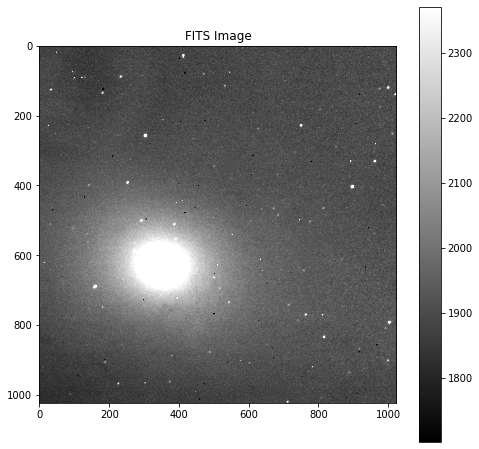

In [35]:
import matplotlib.pyplot as plt
from astropy.visualization import (PercentileInterval, ZScaleInterval, ImageNormalize)
from astropy.io import fits

# Load the FITS file (replace 'your_image_file.fit' with your actual FITS file path)
fits_image = fits.open(output_directory + '/TB_M31_reduced.fit')

# Extract the data from the FITS file (typically in the first HDU)
image_data = fits_image[0].data

# Close the FITS file after extracting the data
fits_image.close()

# Normalize the image for better visualization (optional)
# You can try different intervals like PercentileInterval or ZScaleInterval
norm = ImageNormalize(image_data, interval=ZScaleInterval())

# Display the image using matplotlib
plt.figure(figsize=(8, 8))
plt.imshow(image_data, cmap='gray', norm=norm)
plt.colorbar()
plt.title('FITS Image')
plt.show()


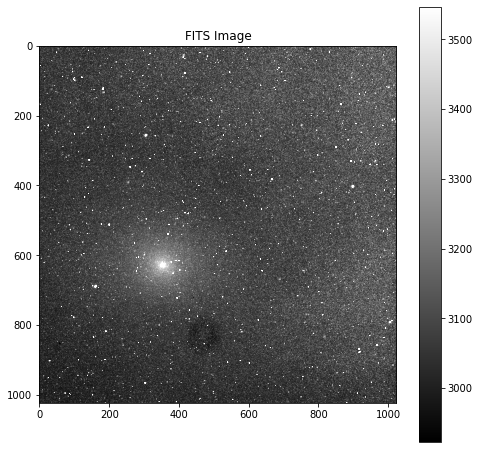

In [36]:
import matplotlib.pyplot as plt
from astropy.visualization import (PercentileInterval, ZScaleInterval, ImageNormalize)
from astropy.io import fits

# Load the FITS file (replace 'your_image_file.fit' with your actual FITS file path)
fits_image = fits.open('/home/idies/workspace/Temporary/treed28/scratch/20240903/TB_M31-001B.fit')

# Extract the data from the FITS file (typically in the first HDU)
image_data = fits_image[0].data

# Close the FITS file after extracting the data
fits_image.close()

# Normalize the image for better visualization (optional)
# You can try different intervals like PercentileInterval or ZScaleInterval
norm = ImageNormalize(image_data, interval=ZScaleInterval())

# Display the image using matplotlib
plt.figure(figsize=(8, 8))
plt.imshow(image_data, cmap='gray', norm=norm)
plt.colorbar()
plt.title('FITS Image')
plt.show()


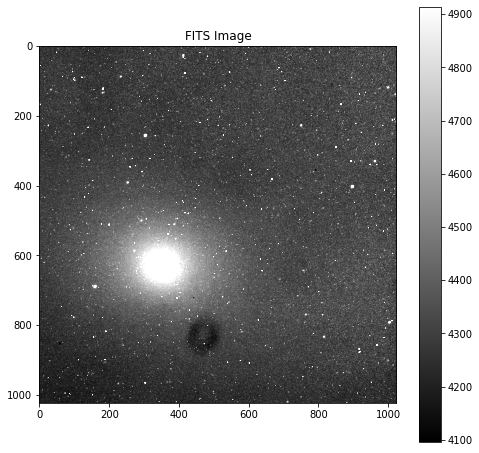

In [37]:
import matplotlib.pyplot as plt
from astropy.visualization import (PercentileInterval, ZScaleInterval, ImageNormalize)
from astropy.io import fits

# Load the FITS file (replace 'your_image_file.fit' with your actual FITS file path)
fits_image = fits.open('/home/idies/workspace/Temporary/treed28/scratch/20240903/TB_M31-001V.fit')

# Extract the data from the FITS file (typically in the first HDU)
image_data = fits_image[0].data

# Close the FITS file after extracting the data
fits_image.close()

# Normalize the image for better visualization (optional)
# You can try different intervals like PercentileInterval or ZScaleInterval
norm = ImageNormalize(image_data, interval=ZScaleInterval())

# Display the image using matplotlib
plt.figure(figsize=(8, 8))
plt.imshow(image_data, cmap='gray', norm=norm)
plt.colorbar()
plt.title('FITS Image')
plt.show()


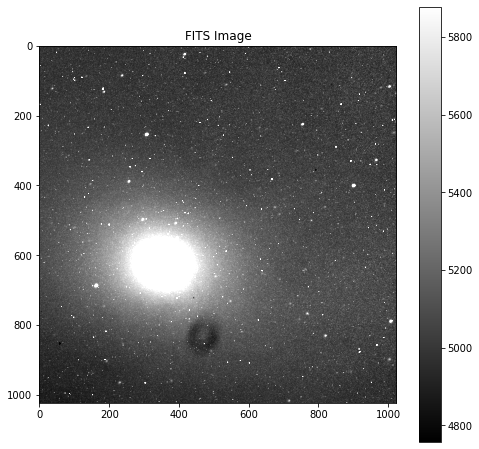

In [38]:
import matplotlib.pyplot as plt
from astropy.visualization import (PercentileInterval, ZScaleInterval, ImageNormalize)
from astropy.io import fits

# Load the FITS file (replace 'your_image_file.fit' with your actual FITS file path)
fits_image = fits.open('/home/idies/workspace/Temporary/treed28/scratch/20240903/TB_M31-001R.fit')

# Extract the data from the FITS file (typically in the first HDU)
image_data = fits_image[0].data

# Close the FITS file after extracting the data
fits_image.close()

# Normalize the image for better visualization (optional)
# You can try different intervals like PercentileInterval or ZScaleInterval
norm = ImageNormalize(image_data, interval=ZScaleInterval())

# Display the image using matplotlib
plt.figure(figsize=(8, 8))
plt.imshow(image_data, cmap='gray', norm=norm)
plt.colorbar()
plt.title('FITS Image')
plt.show()
